In [1]:
import time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import tensorflow as tf
import tensorlayer as tl
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import yfinance as yf

%run "network.ipynb"
%run "environment.ipynb"
%run "relevant.ipynb"

# Data

Import Russell 3000 tickers

In [2]:
# improt RAY tickers retrieved from BB
tickers = pd.read_excel('RAY as of Mar 31 20241.xlsx', sheet_name = 'Tickers')
# tickers = ['AAPL', 'MSFT', 'F', 'AA', 'TSLA', 'NVDA', 'GE']
# replace / with -
tickers['Ticker'] =  [ticker.replace('/', '-') for ticker in tickers['Ticker']]

# convert to a list
tickers = tickers['Ticker'].tolist()
print(f'# tickers: {len(tickers)}')

# tickers: 2949


Exclude the tickers that were not listed at the start date

In [3]:
start = datetime(2014,3,31)
end = datetime(2024,3,31)

OHLCV = {}
new_tickers = []

for ticker in tickers:
    data = yf.download(ticker, start=start, end=end, ignore_tz=True)
    
    # Check if the download returned an empty DataFrame
    if data is not None and not data.empty and len(data) == 2517:
        new_tickers.append(ticker)
        OHLCV[ticker] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [4]:
print(f'# of available tickers is {len(new_tickers)}')

# of available tickers is 1892


Select a sample of 100 stocks that:
- is representative in terms of sector composition;
- includes large, mid and small caps
- avoids look-ahead bias

In [5]:
# Load the data
info = pd.read_excel('RAY as of Mar 31 20241.xlsx', sheet_name = 'Data')
info = info.dropna()

# Calculate the sector distribution
sector_distribution = info['GICS Sector\n'].value_counts(normalize=True)

# Filter for available tickers
info_new = info[info['Ticker'].isin(new_tickers)].reset_index(drop = True)
info_new = info

# Define market cap thresholds (example values, adjust as necessary)
large_cap_threshold = 10e9  # $10 billion
small_cap_threshold = 2e9   # $2 billion

# Classify stocks as large cap, mid cap or small cap
info_new['Cap Size'] = pd.cut(info_new['Market cap'],
                        bins=[-float('inf'), small_cap_threshold, large_cap_threshold, float('inf')],
                        labels=['Small Cap', 'Mid Cap', 'Large Cap'])

# Calculate the number of samples per sector based on original distribution
sample_size = 100
samples_per_sector = (sector_distribution * sample_size).round().astype(int)

In [6]:
# Define desired proportions for large, mid, and small caps
large_cap_proportion = 0.3
mid_cap_proportion = 0.3
small_cap_proportion = 0.4

# Perform stratified sampling to maintain sector distribution and cap sizes
sample_df = pd.DataFrame()

for sector, n_samples in samples_per_sector.items():
    sector_df = info_new[info_new['GICS Sector\n'] == sector]
    large_cap_df = sector_df[sector_df['Cap Size'] == 'Large Cap']
    mid_cap_df = sector_df[sector_df['Cap Size'] == 'Mid Cap']
    small_cap_df = sector_df[sector_df['Cap Size'] == 'Small Cap']
    
    # Calculate initial number of samples for each cap size
    n_large_cap_samples = int(large_cap_proportion * n_samples)
    n_mid_cap_samples = int(mid_cap_proportion * n_samples)
    n_small_cap_samples = n_samples - n_large_cap_samples - n_mid_cap_samples
    
    # Adjust if there are not enough stocks in any cap size category
    n_large_cap_samples = min(n_large_cap_samples, len(large_cap_df))
    n_mid_cap_samples = min(n_mid_cap_samples, len(mid_cap_df))
    n_small_cap_samples = min(n_small_cap_samples, len(small_cap_df))
    
    remaining_samples = n_samples - (n_large_cap_samples + n_mid_cap_samples + n_small_cap_samples)
    
    # Distribute remaining samples proportionally
    while remaining_samples > 0:
        if len(large_cap_df) > n_large_cap_samples:
            n_large_cap_samples += 1
            remaining_samples -= 1
        if remaining_samples == 0:
            break
        if len(mid_cap_df) > n_mid_cap_samples:
            n_mid_cap_samples += 1
            remaining_samples -= 1
        if remaining_samples == 0:
            break
        if len(small_cap_df) > n_small_cap_samples:
            n_small_cap_samples += 1
            remaining_samples -= 1
    
    # Sample the stocks
    sampled_large_cap_df = large_cap_df.sample(n=n_large_cap_samples, random_state=1)
    sampled_mid_cap_df = mid_cap_df.sample(n=n_mid_cap_samples, random_state=1)
    sampled_small_cap_df = small_cap_df.sample(n=n_small_cap_samples, random_state=1)
    
    sampled_sector_df = pd.concat([sampled_large_cap_df, sampled_mid_cap_df, sampled_small_cap_df])
    sample_df = pd.concat([sample_df, sampled_sector_df], ignore_index=True)


In [7]:
len(sample_df)

101

In [8]:
sample_df = sample_df[1:]

In [9]:
sample_distribution = pd.DataFrame(sample_df['GICS Sector\n'].value_counts(normalize=True))
sample_distribution

,proportion
GICS Sector,
Health Care,0.18
Financials,0.17
Industrials,0.15
Information Technology,0.12
Consumer Discretionary,0.12
Real Estate,0.06
Energy,0.05
Materials,0.05
Communication Services,0.04


In [10]:
sample_distribution1 = pd.DataFrame(sample_df['Cap Size'].value_counts(normalize=True))
sample_distribution1

,proportion
Cap Size,
Small Cap,0.51
Mid Cap,0.25
Large Cap,0.24


Compute features

In [11]:
sampled_tickers = sample_df['Ticker'].tolist()
len(sampled_tickers)

100

In [12]:
# import pickle

# with open('sample.pkl', 'wb') as file:
#     # Use pickle to dump the list to the file
#     pickle.dump(sampled_tickers, file)

In [13]:
features = {}

for ticker, df in tqdm(OHLCV.items(), desc="Calculating features"):
    if ticker in sampled_tickers:
        features[ticker] = relevant_indicators(df)

Calculating features: 100%|██████████| 1892/1892 [00:50<00:00, 37.41it/s]


In [14]:
len(features.keys())

66

In [15]:
combined_features = pd.concat(features, axis=1)
combined_features.columns.names = ['stock', 'indicator']
combined_features = combined_features.dropna()

In [16]:
# with open('features.pkl', 'wb') as file:
#     # Use pickle to dump the list to the file
#     pickle.dump(combined_features, file)

# Clustering

compute returns

In [17]:
returns = {}

for ticker, df in OHLCV.items():
    if ticker in sampled_tickers:
        returns[ticker] = df['Adj Close'].pct_change().dropna()

In [18]:
returns = pd.concat(returns, axis=1)

In [19]:
returns.shape

(2516, 66)

In [20]:
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)
scaled_returns_df = pd.DataFrame(scaled_returns, index=returns.index, columns=returns.columns)

try different random states to find the best clustering model -> stocks well-distributed among clusters

In [21]:
# List of random states to try
random_states = range(0, 100)

# Variables to store the best result
best_random_state = None
best_silhouette_score = -1
best_model = None

# Try different random states
for state in tqdm(random_states, desc="Testing models"):
    kmeans = KMeans(n_clusters=10, init='k-means++', random_state=state, n_init = 10)
    kmeans.fit(scaled_returns_df.T)
    labels = kmeans.labels_
    
    # Evaluate clustering performance
    silhouette_avg = silhouette_score(scaled_returns_df.T, labels)
    davies_bouldin_avg = davies_bouldin_score(scaled_returns_df.T, labels)
    
    # print(f"Random State: {state}, Silhouette Score: {silhouette_avg}, Davies-Bouldin Score: {davies_bouldin_avg}")
    
    # Update the best model if current one is better
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_random_state = state
        best_model = kmeans

print(f"Best Random State: {best_random_state}, Best Silhouette Score: {best_silhouette_score}")

# Best model labels
clustering = best_model.labels_
clustering

Testing models: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]

Best Random State: 95, Best Silhouette Score: 0.025474642175620302


array([5, 8, 8, 1, 8, 8, 8, 2, 2, 8, 5, 0, 8, 1, 2, 7, 1, 5, 3, 5, 4, 8,
       8, 8, 5, 4, 8, 1, 4, 8, 5, 1, 4, 2, 8, 5, 8, 2, 2, 1, 9, 2, 6, 1,
       5, 2, 2, 5, 5, 8, 5, 8, 6, 8, 8, 8, 8, 6, 5, 5, 8, 8, 5, 2, 2, 8])

In [22]:
len(clustering)

66

In [23]:
np.unique(clustering, return_counts=True) # after returns normalization, the stocks are well-distribuited along the clusters

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 1,  7, 11,  1,  4, 14,  3,  1, 23,  1], dtype=int64))

In [24]:
# with open('clusters.pkl', 'wb') as file:
#     # Use pickle to dump the list to the file
#     pickle.dump(clustering, file)

# Training

In [25]:
import pickle

with open('sample.pkl', 'rb') as file:
    # Use pickle to load the list from the file
    sampled_tickers = pickle.load(file)

with open('clusters.pkl', 'rb') as file:
    # Use pickle to load the list from the file
    clustering = pickle.load(file)

with open('features.pkl', 'rb') as file:
    # Use pickle to dump the list to the file
    combined_features = pickle.load(file)

In [26]:
np.unique(clustering)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [27]:
def optimize_memory_usage(df):
    # Example of downcasting numerical data
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

In [28]:
history = optimize_memory_usage(combined_features)
# history = combined_features

In [29]:
window_length = 20 # for obs|

train_steps = int(0.6*len(history.index[window_length:]))
val_steps = int(0.2*len(history.index[window_length:]))
test_steps = int(0.2*len(history.index[window_length:]))

In [30]:
# set the env input
abbreviation = sampled_tickers # name of stock
# steps = 250 # step for one eps
trading_cost = 0.005
time_cost = 0.00 # cost of holding equity
eps_move = 0 # move the start date after each rest
sample_start_date = "2014-08-11" # start of the training


# build the actor, critic, and target network 
gamma = 1 # discount factor
state_shape = [None,len(abbreviation),window_length,15] # (none, m_stock, history_window, feature)
action_shape = [None,len(abbreviation)+1] # (none, m_stock)
a_learning_rate = 0.001 # learning rate for actor

In [31]:
# Override the function in the tensorlayer.files.utils module
def _load_weights_from_hdf5_group_in_order(f, layers):
    """
    Load layer weights from a hdf5 group sequentially.
    """
    layer_names = f.attrs["layer_names"]

    # If layer_names are bytes, decode them
    if isinstance(layer_names[0], bytes):
        layer_names = [n.decode('utf8') for n in layer_names]

    for idx, name in enumerate(layer_names):
        g = f[name]
        weights = [np.array(g[n]) for n in g.attrs['weight_names']]
        # Check if the layer has the 'set_weights' attribute
        if hasattr(layers[idx], 'set_weights'):
            layers[idx].set_weights(weights)

# Assign the new function to the tensorlayer.files.utils module
tl.files.utils._load_weights_from_hdf5_group_in_order = _load_weights_from_hdf5_group_in_order

In [32]:
# clustering_with_bias = np.concatenate([clustering, [clustering.max()+1]])

In [33]:
# np.unique(clustering_with_bias)

In [36]:
# Forward Stepping Test

TRAIN_EPISODES = 200

# hyperparameters in the reward function
alpha = 0.1
beta = 0
gamma_ = 0 # i don't need it anymore

train = True
RENDER = False

ALG_NAME = "MCPG"
ENV_ID = "Portfolio_Env"

eps_move = 0 # static training period

# training env
PM_env = PortfolioEnv(history.iloc[:,:], abbreviation, train_steps, trading_cost,\
                                   time_cost, window_length, eps_move, sample_start_date,\
                                   alpha, beta ,gamma_
                                  )


state_shape = [None,len(abbreviation),window_length,15]

# build the model
a =  Actor_NetWork(gamma, state_shape,action_shape,a_learning_rate, layers=[], clustering=clustering)
print(a.actor_network)

VAL_EPISODES = TRAIN_EPISODES
VAL_steps = val_steps # total steps for validation period


# set the validation start date right after the end of train data
val_start_date = str(history.loc[sample_start_date:].index[train_steps])
val_start_date = val_start_date[0:10] # only need year-month-day

# valid env
val_PM_env = PortfolioEnv(history.iloc[:,:], abbreviation, VAL_steps, trading_cost,\
                                   time_cost, window_length, eps_move, val_start_date,\
                                    alpha, beta ,gamma_
                                  )



weight_track = {} 
weighted_rank = [] # i don't need it anymore 
for name in abbreviation:
    weight_track[name] = []

returns = []

t0 = time.time()
patience = 20
best_reward = -float('inf')
if train:  # train
    test_state, test_info = val_PM_env.reset() # here test is meant as validate
    print('start')
    
    for episode in range(TRAIN_EPISODES):
        state_trajectory = []
        reward_trajectory = []
        prev_action_trajectory = []
        ###################################### Train the model ############################################
        state, info = PM_env.reset()
        episode_reward = 0
        prev_action = np.zeros((1, action_shape[1]), dtype=np.float32)
        print('run one episode')
        for step in range(train_steps):
            #print(state)
            if RENDER:
                PM_env.render()
            # Add exploration noise
            state_trajectory.append(state) # 0,1, ..., T-1
            prev_action_trajectory.append(prev_action)
            action = a.Generate_action(state, prev_action=prev_action, greedy = False) #[[a0, a1, a2]]
            
            
            #print(action)
            state_, reward, done, info = PM_env.step(action) # compute the immediate reward and move to next steps
            #print(info)
            state = state_
            reward_trajectory.append(reward * gamma**step)
            episode_reward += reward * gamma**step # reward discounting
            prev_action = action
            if done:
                break

        
        
             
        print('update the actor network')
        batch_size = 250
        G = np.cumsum(reward_trajectory[::-1])[::-1] # compute the G_t
        for step in range(0, len(reward_trajectory), batch_size):
            Gt = G[step: step+batch_size] 
            St = state_trajectory[step: step+batch_size]
            prev_action = prev_action_trajectory[step: step+batch_size]
            St = np.vstack(St)
            Gt = np.vstack(Gt)
            prev_action = np.vstack(prev_action)
            a.learn(St, Gt, prev_action)
        a.save()
        ###################################### Validate the model ############################################
        # test
        a.load() # load previous parameters
        rets = []
        test_state, _ = val_PM_env.reset()
        prev_action = None
        for step in range(VAL_steps):
            test_action = a.Generate_action(test_state, prev_action=prev_action, greedy = True)
            test_state, reward, done, info = val_PM_env.step(test_action)
            prev_action = test_action
            for i in range(len(abbreviation)):
                name = abbreviation[i]
                weight_track[name].append(test_action[0][i])
            weighted_rank.append(val_PM_env.sim.weighted_rank) # maybe i don't need it anymore ???
            rets.append(info['average_return'])
            
            if done:
                break
        rets = np.array(rets)
        returns.append(rets.sum())  

        
        print(
            'Testing  | Episode: {}/{} | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                episode + 1, TRAIN_EPISODES, 
                episode_reward,
                time.time() - t0
            )
        )
        if episode > 20:
            if episode_reward > best_reward:
                print(f'Reward improved from {best_reward} to {episode_reward}')
                best_reward = episode_reward
                patience = 20
            else:
                print(f'Reward did not improve')
                patience -= 1
            if patience == 0: break

            val_PM_env.render() 

[TL] Input  _inputlayer_7: [None, 100, 20, 15]
[TL] Input  _inputlayer_8: (None, 100)
[TL] Input  _inputlayer_9: (None, 1)
[TL] Reshape reshape_3
[TL] Conv2d conv1: n_filter: 4 filter_size: (1, 3) strides: (1, 1) pad: SAME act: relu
(1, 100, 20, 4)
[TL] Conv2d conv2: n_filter: 40 filter_size: (1, 20) strides: (1, 1) pad: VALID act: relu
(1, 100, 1, 40)
(1, 100, 1, 1)
[TL] Concat concat_5: concat_dim: -1
(1, 100, 1, 41)
[TL] Conv2d conv3: n_filter: 1 filter_size: (1, 1) strides: (1, 1) pad: VALID act: relu
(1, 100, 1, 1)
[TL] Flatten flatten_3:
(1, 100)
[TL] Dropout dropout_3: keep: 0.700000 
[TL] Dense  output: 1 No Activation
[TL] Concat concat_6: concat_dim: -1
[TL] Lambda  lambda_3: func: <keras.src.layers.activation.softmax.Softmax object at 0x0000021C7F944C70>, len_weights: 0
model_2(
  (_inputlayer_7): Input(shape=[None, 100, 20, 15], name='_inputlayer_7')
  (reshape_3): Reshape(shape=(-1, 100, 1, 1),name='reshape_3')
  (output): Dense(n_units=1, No Activation, in_channels='1', n

KeyboardInterrupt: 

# Testing

In [31]:
# test = True
TEST_EPISODES = TRAIN_EPISODES
TEST_steps = test_steps-20


# set the test start date right after the end of valid data
test_start_date = str(history.loc[val_start_date:].index[val_steps])
test_start_date= test_start_date[0:10] # only need year-month-day

[*********************100%%**********************]  1 of 1 completed


<Figure size 640x480 with 0 Axes>

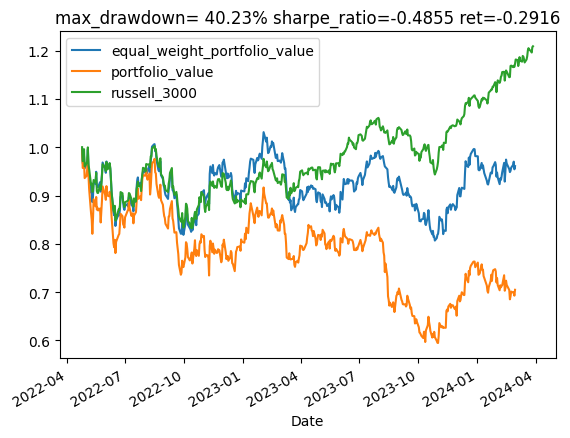

[TL] [*] Saving TL weights into model\MCPG_PM\actor.hdf5
[TL] [*] Saved


In [32]:
# test env
# test_start_date='2020-02-16'
test_PM_env = PortfolioEnv(history, abbreviation, TEST_steps, trading_cost,\
                                   time_cost, window_length, eps_move, test_start_date,\
                                   alpha, beta ,gamma_
                                  )


test_PM_env.src.reset_pointer = 0
test_state, _ = test_PM_env.reset()
prev_action = None
actions = []
for step in range(TEST_steps):
    test_action = a.Generate_action(test_state, greedy = True, prev_action = prev_action) # greedy = True : NO randomness
    actions.append(test_action)
    test_state, reward, done, info = test_PM_env.step(test_action)
    prev_action = test_action
    
    if done:
        break
test_PM_env.render()     

# import Russell 3000 time series
russell = yf.download('^RUA', start = test_start_date, end = '2024-03-31', ignore_tz = True)['Close']
rua_evol = russell / russell[0]
rua_evol.plot(label='russell_3000')
plt.legend()
plt.show()
a.save()

In [33]:
test_action

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.09999999, 0.        ,
        0.        , 0.        , 0.        , 0.09999999, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.09999999, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

# weights

In [38]:
tmp = test_PM_env.src._data.loc[test_start_date:]
idx = tmp.index.get_loc('2022-06-10')

df = pd.DataFrame(actions[idx])
df.columns = ['cash', *sampled_tickers]

In [39]:
df = df.T
weights = df[df > 0].dropna()
weights

,0
TECH,0.1
ARWR,0.1
PAR,0.1
LAND,0.1
SXT,0.1
CMCL,0.1
CCO,0.1
STKL,0.1
MED,0.1
HE,0.1


# Backtest

In [ ]:
# # set the backtest input
# backtester_start_date = '2017-08-01'
# backtester_steps  = 1600

In [ ]:
# # backtest env (move away from here)
# backtester_PM_env = PortfolioEnv(history, abbreviation, backtester_steps, trading_cost,\
#                                    time_cost, window_length, eps_move, backtester_start_date,\
#                                    alpha, beta ,gamma_, clustering=clustering
#                                   )


# backtester_PM_env.src.reset_pointer = 0
# test_state, _ = backtester_PM_env.reset()
# prev_action = None
# for step in range(backtester_steps):
#     if step%30 == 0:
#         test_action = a.Generate_action(test_state, greedy = True, prev_action = prev_action)

#     test_state, reward, done, info = backtester_PM_env.step(test_action)
#     prev_action = test_action
    
#     if done:
#         break
# backtester_PM_env.render()       
# a.save()